In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import scienceplots
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use("science")
import corner

from synthpop.models import AxtellModel
from synthpop.infer import Infer, SMCABC
from synthpop.generative import SampleGenerator
import pygtc

/Users/arnull/miniconda3/envs/torch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1 . Define model and loss function

In [4]:
model = AxtellModel(N=1000, v=1)

def loss(x):
    ts, ass, _, efforts = x
    init_mean_efforts = efforts[0].mean()
    previous_efforts = efforts[0].copy()
    for i in range(len(ts) - 1):
        agent = ass[i+1]
        previous_efforts = model.reconstruct_effort(previous_efforts, agent, efforts[i+1])
    return (previous_efforts.mean() - init_mean_efforts) + 1

class MetaGenerator(SampleGenerator):
    def forward(self, generator_params):
        E_a, E_b, T_a, T_b, P_k, P_t, beta, a, b = generator_params
        def generator(n_agents):
            # Draw effort levels
            es  = np.random.beta(E_a, E_b, size=n_agents)
            # Draw preferences
            ths = np.random.beta(T_a, T_b, size=n_agents)
            # Draw rates
            phs = np.random.gamma(P_k, P_t, size=n_agents)
            return es, ths, phs, beta.item(), a.item(), b.item()
        return generator

# 2. SMCABC

In [5]:
prior = torch.distributions.Independent(torch.distributions.Uniform(torch.tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]),
                                    torch.tensor([2., 2, 2, 2, 2, 1, 4, 5, 5])), reinterpreted_batch_ndims=1)
meta_generator = MetaGenerator()
infer = Infer(model=model, meta_generator=meta_generator, prior=prior, loss=loss)
infer_method = SMCABC(num_particles = 10_000, num_initial_pop=20_000, num_simulations=50_000, epsilon_decay=0.8)
trained_meta_generator = infer.fit(infer_method, num_workers=-1)

Running 20000 simulations in 20000 batches.: 100%|██████████| 20000/20000 [01:20<00:00, 249.40it/s]
/Users/arnull/miniconda3/envs/torch2/lib/python3.10/site-packages/sbi/inference/abc/smcabc.py:569: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1702.)
  torch.cholesky(kernel_variance_scale * population_cov)
Running 3496 simulations in 3496 batches.: 100%|██████████| 3496/3496 [00:12<00:00, 280.27it/s]


In [6]:
#samples = trained_meta_generator.samples.numpy()
#pygtc.plotGTC([samples], 
#              paramNames=[r"$\epsilon_a$", r"$\epsilon_b$",
#                        r"$\tau_a$", r"$\tau_b$",
#                        r"$\rho_a$", r"$\rho_b$",
#                        r"$\beta$", r"$a$", r"$b$"]);

In [7]:
# get predicted efforts.
def get_mean_efforts(ts, ass, a_efforts):
    mean_efforts = [a_efforts[0].mean()]
    last_efforts = a_efforts[0]
    for i in range(len(ts) - 1):
        agent = ass[i+1]
        new_efforts = model.reconstruct_effort(last_efforts, agent, a_efforts[i+1])
        mean_efforts.append(new_efforts.mean())
        last_efforts = new_efforts
    return mean_efforts

def get_pred_efforts_from_generator(meta_generator, n = 25):
    pred_efforts = []
    times = []
    for j in range(n):
        generator = meta_generator()
        ts, ass, _, a_efforts = model(generator)
        mean_efforts= get_mean_efforts(ts, ass, a_efforts)
        pred_efforts.append(mean_efforts)
        times.append(ts)
    return times, pred_efforts

prior_times, prior_pred_efforts = get_pred_efforts_from_generator(lambda: meta_generator(prior.sample()))
post_times, post_pred_efforts = get_pred_efforts_from_generator(trained_meta_generator)

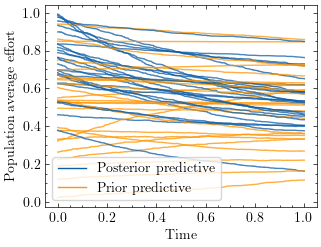

In [8]:
fig, ax = plt.subplots(1,1)
alpha = 0.75
for i in range(len(post_pred_efforts)):
    ax.plot(post_times[i], post_pred_efforts[i], alpha=alpha, c="C0")
    ax.plot(prior_times[i], prior_pred_efforts[i], alpha=alpha, c="C2")
ax.plot([], [], color = "C0", label="Posterior predictive")
ax.plot([], [], color = "C2", label="Prior predictive")
plt.legend(facecolor='white', framealpha=0.8, frameon=True, loc="lower left")
ax.set_ylabel("Population average effort")
ax.set_xlabel("Time")
fig.savefig("../figures/paper/axtell_effort_smcabc.pdf", bbox_inches="tight")

# 3. Variational Inference

In [23]:
from synthpop.generative import MaskedAutoRegressiveFlow
from synthpop.infer import VI

class FlowMetaGenerator(MaskedAutoRegressiveFlow):
    prior_min = torch.tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) + 1e-8 # tolerance
    prior_max = torch.tensor([2., 2, 2, 2, 2, 1, 4, 5, 5]) - 1e-8
    def forward(self, generator_params=None):
        if generator_params is None:
            generator_params = self.sample(1)[0][0]
        # constrain parameters to prior range
        params = torch.sigmoid(generator_params)
        params = self.prior_min + (self.prior_max - self.prior_min) * params
        def generator(n_agents):
            E_a, E_b, T_a, T_b, P_k, P_t, beta, a, b = params
            # Draw effort levels
            es  = np.random.beta(E_a, E_b, size=n_agents)
            # Draw preferences
            ths = np.random.beta(T_a, T_b, size=n_agents)
            # Draw rates
            phs = np.random.gamma(P_k, P_t, size=n_agents) 
            return es, ths, phs, beta.item(), a.item(), b.item()
        return generator
flow_meta_generator = FlowMetaGenerator(n_parameters = 9, n_hidden_units = 32, n_transforms = 4)

In [24]:
# make aux prior so that regularisation loss is the entropy.
inff = 1000
prior_vi = torch.distributions.Independent(torch.distributions.Uniform(-inff * torch.ones(9), inff * torch.ones(9)), 1)
infer = Infer(model=model, meta_generator=flow_meta_generator, prior=prior_vi, loss=loss)
optimizer = torch.optim.AdamW(flow_meta_generator.parameters(), lr=1e-3)
infer_method = VI(w=1, n_samples_per_epoch=50, optimizer=optimizer, 
                    progress_bar=True, 
                    progress_info=True, 
                    gradient_estimation_method="score", 
                    log_tensorboard=True, 
                    gradient_clipping_norm=10.0,
                    )
infer.fit(infer_method, n_epochs=1000, max_epochs_without_improvement=np.inf);

 42%|████▏     | 421/1000 [21:44<29:54,  3.10s/it, loss=0.25, reg=5.14, total=5.39, best loss=5.38, epochs since improv.=1]  


KeyboardInterrupt: 

In [25]:
# load best model
flow_meta_generator.load_state_dict(torch.load("./best_estimator.pt"))

<All keys matched successfully>

In [26]:
with torch.no_grad():
    #prior_times, prior_pred_efforts = get_pred_efforts_from_generator(meta_generator(prior.sample()))
    flow_post_times, flow_post_pred_efforts = get_pred_efforts_from_generator(flow_meta_generator)

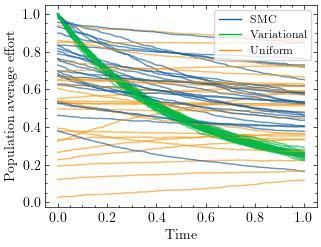

In [27]:
fig, ax = plt.subplots(1,1)
alpha = 0.65
for i in range(len(post_pred_efforts)):
    ax.plot(post_times[i], post_pred_efforts[i], alpha=alpha, c="C0")
    ax.plot(flow_post_times[i], flow_post_pred_efforts[i], alpha=alpha, c="C1")
    ax.plot(prior_times[i], prior_pred_efforts[i], alpha=alpha, c="C2")
ax.plot([], [], color = "C0", label="SMC")
ax.plot([], [], color = "C1", label="Variational")
ax.plot([], [], color = "C2", label="Uniform")
ax.legend(facecolor='white', framealpha=0.8, frameon=True, fontsize=8)
ax.set_ylabel("Population average effort")
ax.set_xlabel("Time")
fig.savefig("../figures/paper/axtell_effort.pdf", bbox_inches="tight")

In [30]:
# plot flow
with torch.no_grad():
    samples = flow_meta_generator.sample(10000)[0]
    #samples = torch.sigmoid(samples)
    #samples = flow_meta_generator.prior_min + samples * (flow_meta_generator.prior_max - flow_meta_generator.prior_min)

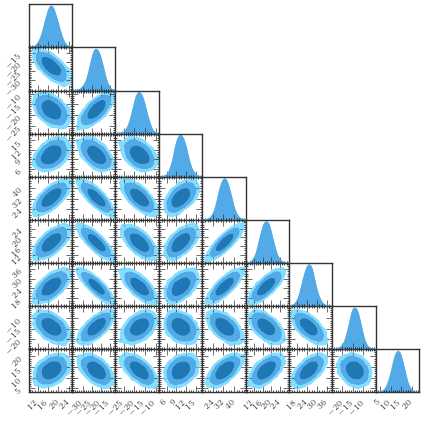

In [31]:

pygtc.plotGTC([samples.numpy()], 
              figureSize="MNRAS_page",
              nContourLevels=3, 
              );